In [55]:
# Importing the modules for collecting and building the dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
import re
import cv2

# Image processing...
from PIL import Image, ImageOps

from pathlib import Path


In [56]:
# %load_ext tensorboard
import tensorflow as tf
print(tf.__version__)
import datetime

2.3.0


In [57]:
# Importing standard ML set - numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Importing keras and its deep learning tools - neural network model, layers, contraints, optimizers, callbacks and utilities
from tensorflow.keras import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling

# Importing scikit-learn tools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [58]:
def scale(im):
    return cv2.resize(im, (imgSize,imgSize))

In [59]:
testPath = './datasets/AugTest/'
trainPath = './datasets/AugTrain/'
imgSize = 100
n_channels = 1

In [60]:
# Setting up the image pool

def load_image_files(container_path):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]
    print("Total Manufacturers:",len(categories))
    count = 0
    imgs = []
    y = []
    for i, direc in enumerate(folders):
        count = 0
        for file in direc.iterdir():
            count += 1
            imgs.append(scale(np.array(ImageOps.grayscale(Image.open(file)))).flatten())
            y.append(i)
    print(len(imgs),imgs[0].shape)
    X = np.array(imgs, order='F', dtype='uint8')
    y = np.asarray(y, dtype='uint8')
    return [X,y,categories]

In [61]:
X_test,y_test,_ = load_image_files(testPath)
X_train,y_train,logos = load_image_files(trainPath)
X_test,y_test = shuffle(X_test, y_test, random_state=42) 
X_train,y_train = shuffle(X_train, y_train, random_state=42) 

Total Manufacturers: 19
3368 (10000,)
Total Manufacturers: 19
4329 (10000,)


(10000,) (10000,)


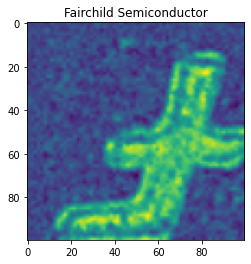

In [62]:
r = 123
print(X_train[0].shape, X_train[1].shape)
plt.imshow(X_train[r].reshape(imgSize, imgSize, 1))
plt.title(logos[y_train[r]])
plt.show()

In [63]:
X_test_img = X_test.copy()
y_test_img = y_test.copy()
# let's bring back the images, like above
X_train = X_train.reshape(X_train.shape[0], imgSize, imgSize, n_channels)
X_test = X_test.reshape(X_test.shape[0], imgSize, imgSize, n_channels)

# Now for some convergence-friendly procedure (is supposed to converge a lot faster when brought to 0-1 float)...
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# ...and some additional pre-processing, to zero-center the data...
X_train = np.subtract(X_train, 0.5)
X_test = np.subtract(X_test, 0.5)

# ...and to scale it to (-1, 1)
X_train = np.multiply(X_train, 2.0)
X_test = np.multiply(X_test, 2.0)

# Labels have to be transformed to categorical
Y_train = np_utils.to_categorical(y_train, num_classes=len(logos))
Y_test = np_utils.to_categorical(y_test, num_classes=len(logos))

In [64]:
# Finally for some CNN construction!

# setting up batch size
batch = 24

# there are 40 brands altogether, so far, but let's make it official
n_classes = len(logos)

# setting up the number of epochs to be trained
n_epochs = 30

# images are RGB, so they use up 3 channels for Red, Green and Blue, respectively


In [65]:
# Convolutional Neural Network will be composed of four Conv/MaxPool blocks, a flattening layer and two dense layers at the end
# (before the final classification layer, that is)

# The model will have a sequential architecture
# NOTE: kernel and bias had to be fine-tuned in order to increase the chance of converging

model = Sequential()
model.add(Conv2D(32, (3,3),
                 input_shape=(imgSize,imgSize,n_channels),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(len(logos), activation='softmax'))

checkpoint_path = ".\\Checkpoints\\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Some callbacks have to be provided to choose the best trained model
# patience set at 4 as 3 was too greedy - I observed better results after the third-worse epoch
early_stopping = EarlyStopping(patience=2, monitor='val_loss')
take_best_model = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1, save_best_only=True)

# optimizer will be a stochastic gradient descent, learning rate set at 0.005
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

# Let's look at the summary
model.summary()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)        

In [66]:
# model.fit(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),\
#                     steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,\
#                     validation_data=(X_test, Y_test), workers=4,callbacks=[early_stopping,take_best_model])
model.fit(X_train, Y_train, batch_size=batch, shuffle=True, epochs=n_epochs, verbose=1, validation_data=(X_test, Y_test),steps_per_epoch=X_train.shape[0]//batch, workers=4,
         callbacks=[early_stopping,take_best_model,tensorboard_callback])

Epoch 1/30
180/180 [==============================] - ETA: 0s - loss: 1.8433 - categorical_accuracy: 0.4468
Epoch 00001: val_loss improved from inf to 1.29106, saving model to .\Checkpoints\cp.ckpt
180/180 [==============================] - 181s 1s/step - loss: 1.8433 - categorical_accuracy: 0.4468 - val_loss: 1.2911 - val_categorical_accuracy: 0.6381
Epoch 2/30
180/180 [==============================] - ETA: 0s - loss: 0.3871 - categorical_accuracy: 0.9020
Epoch 00002: val_loss improved from 1.29106 to 1.13021, saving model to .\Checkpoints\cp.ckpt
180/180 [==============================] - 156s 865ms/step - loss: 0.3871 - categorical_accuracy: 0.9020 - val_loss: 1.1302 - val_categorical_accuracy: 0.7497
Epoch 3/30
180/180 [==============================] - ETA: 0s - loss: 0.1591 - categorical_accuracy: 0.9656
Epoch 00003: val_loss did not improve from 1.13021
180/180 [==============================] - 154s 853ms/step - loss: 0.1591 - categorical_accuracy: 0.9656 - val_loss: 1.9410 - 

In [67]:
scores = model.evaluate(X_test, Y_test) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

106/106 [==============================] - 21s 194ms/step - loss: 2.2821 - categorical_accuracy: 0.7212
Accuracy test: 72.12%


In [68]:
# I will need that later to re-convert my flattened images to their previous state
def ImageConvert(n, i):
    im_ex = i.reshape(n, imgSize, imgSize, 1)
    im_ex = im_ex.astype('float32') / 255
    im_ex = np.subtract(im_ex, 0.5)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

# Metrics of success

In [69]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# Preparing for metrics check-up on the test set, may take a while...
Y_pred = np.argmax(model.predict(X_test), axis=-1)
print(Y_pred.shape,y_test.shape,X_test.shape)

(3368,) (3368,) (3368, 100, 100, 1)


In [70]:
precision, recall, f1, support = prfs(y_test, Y_pred, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}\nAccuracy: {:.2%}".format(precision, recall, f1, scores[1]))

Precision: 78.79%
Recall: 72.12%
F1 score: 71.85%
Accuracy: 72.12%


In [71]:
# But let's check per class, too - assuming that larger datasets will be having higher metrics
precision_, recall_, f1_, support_ = prfs(y_test, Y_pred)
print(f1_.shape,recall_.size,f1_.size)
x = range(len(logos))
print(x)

(19,) 19 19
range(0, 19)


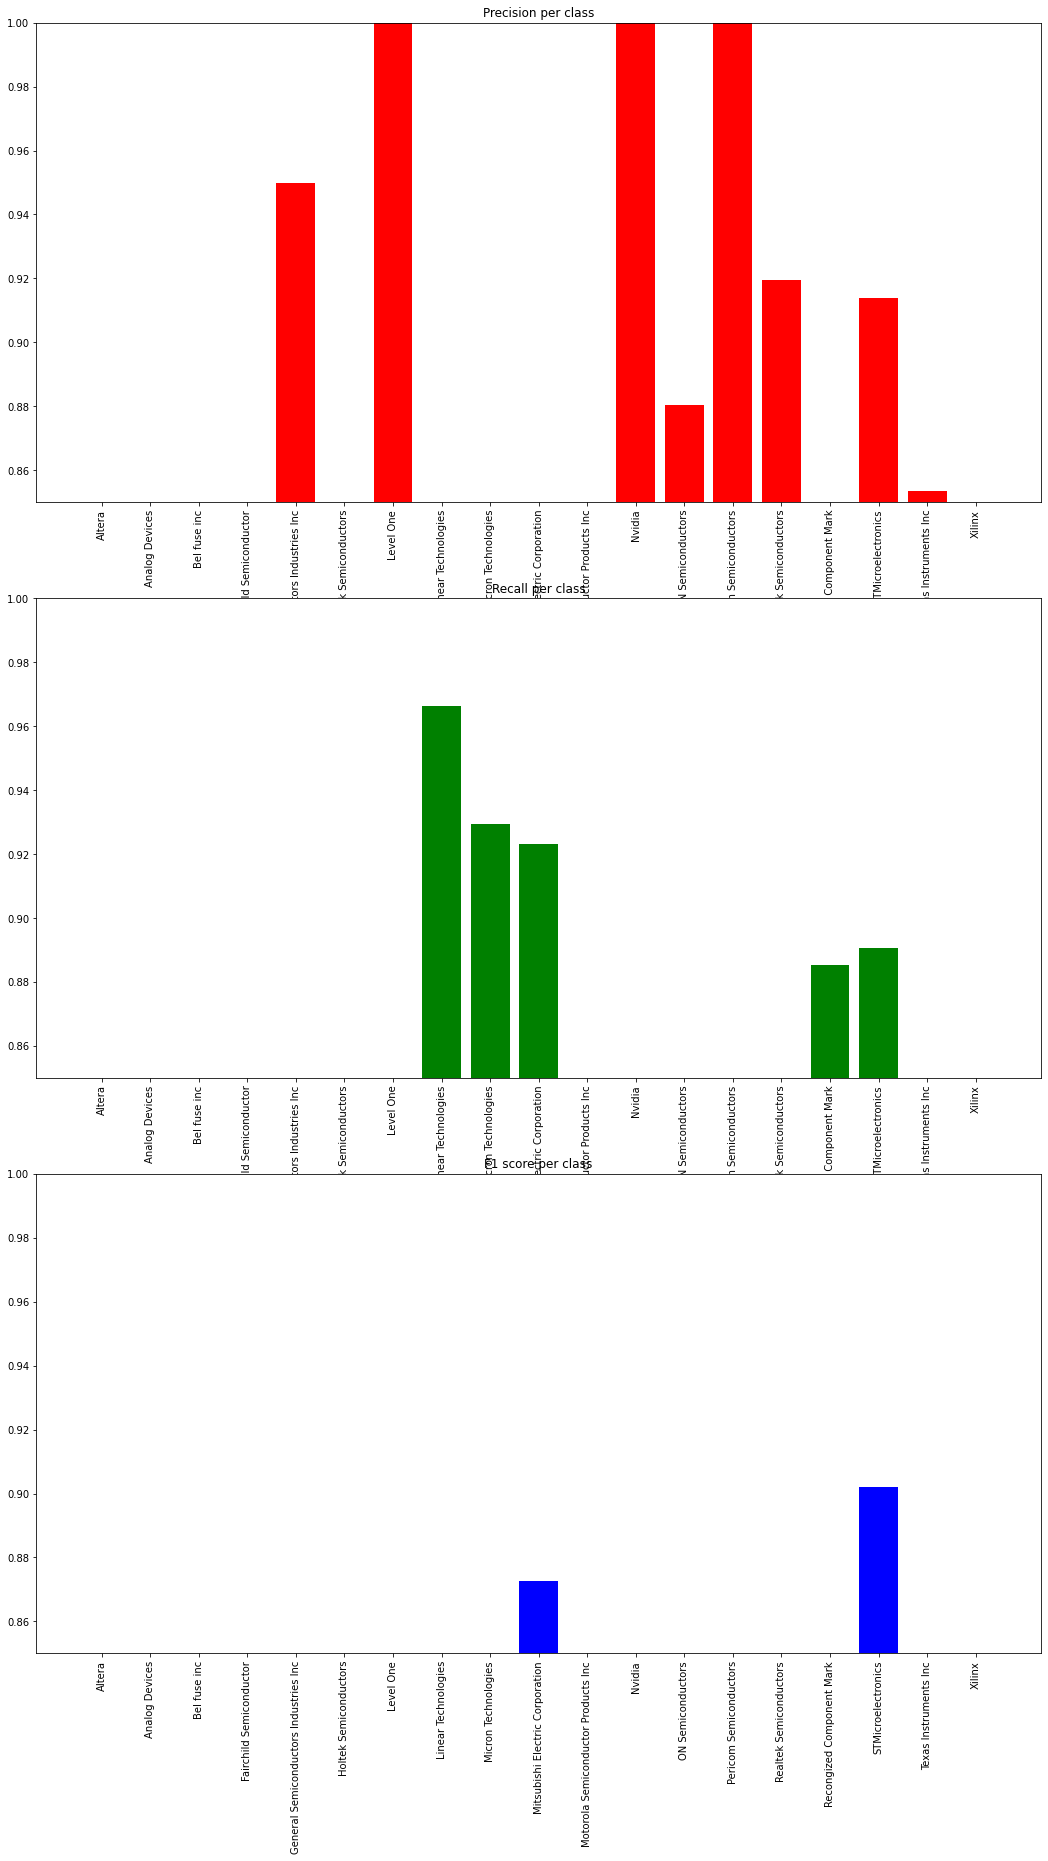

In [72]:
plt.subplots(figsize=(18,30))
x = range(len(logos))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0.85, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, logos, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0.85, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, logos, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0.85, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, logos, rotation = 90)
plt.show()

# Showcasing

In [73]:
# OK, let's try the CNN in action - first defining the ShowCase() method to show everything nicely
def ShowCase(cols, rows):
    fdict = {'fontsize': 24,
            'fontweight' : 'normal',
            'verticalalignment': 'baseline'}
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35,  wspace=2)
    c = 0
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        
        # r - randomly picked from the whole dataset
        r = np.random.randint(np.shape(X_test_img)[0])
        
        # j - predicted class for the image of index r (weird syntax, but works :)
        j = int(np.argmax(model.predict(ImageConvert(1, X_test_img[r:r+1]), verbose=0), axis=-1))
        
        # increase success if predicted well
        if y_test_img[j]:
            c += 1
        
        # image needs reshaping back to a 50px*50px*RGB
        plt.imshow(X_test[r].reshape(imgSize, imgSize, 1))
        
        # plt.title will show the true brand and the predicted brand
        plt.title('True brand: '+logos[y_test_img[r]]+'\nPredicted: '+logos[j],
                  color= 'Green' if logos[y_test_img[r]] == logos[j] else 'Red', fontdict=fdict) # Green for right, Red for wrong
        
        # no ticks
        plt.xticks(())
        plt.yticks(())
        
    # print out the success rate
    print('Success rate: {}/{} ({:.2%})'.format(c, rows*cols, c/(rows*cols)))
    
    plt.show()

Success rate: 43/50 (86.00%)


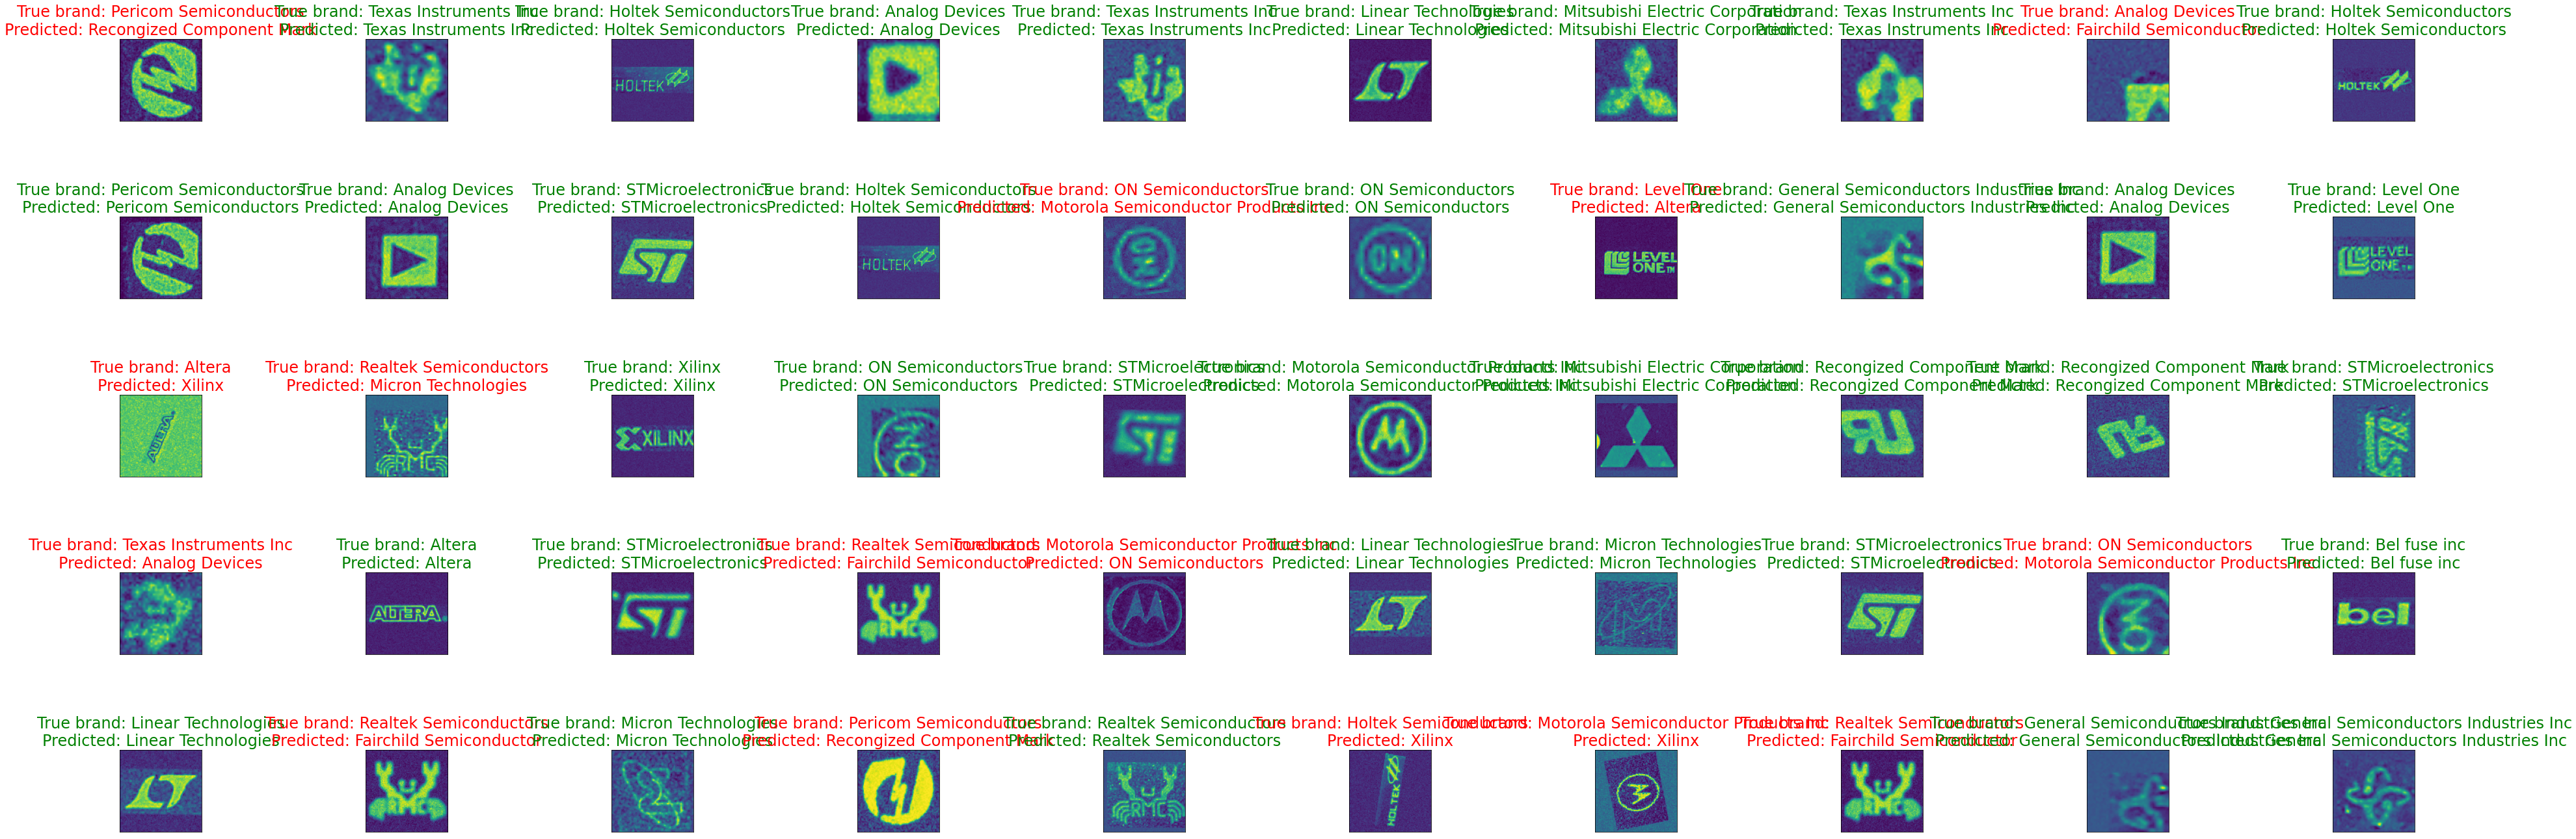

In [74]:
# That is strictly for the showcasing, how the CNN works - ain't that bad, after all :)
ShowCase(10, 5)

In [75]:
# Setting up the image pool
new_image_path = 'Test_images/'
new_imgs = os.listdir(new_image_path)
new_n_samples = np.size(new_imgs)
new_n_samples # 8

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Test_images/'

In [ ]:
# Let's do some showcasing on-the-fly....
cols = 3
rows = 3
plt.figure(figsize=(cols * 5, rows * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(new_n_samples):
    plt.subplot(rows, cols, i + 1)
    im = Image.open(new_image_path+new_imgs[i]).convert("RGB")
    new_im=scale(np.array(im)).flatten()
    # new_im = np.array(im.resize((50,50))).flatten()
    # np.argmax(model.predict(ImageConvert(1, images[r:r+1]), verbose=0))
    m = int(np.argmax(model.predict(ImageConvert(1, new_im), verbose=0), axis=-1))
    plt.imshow(new_im.reshape(img_x, img_y, 3))
    plt.title('Predicted brand: '+logos[m], size=24)
    plt.xticks(())
    plt.yticks(())
plt.show()

# More analysis


In [ ]:
# let's extract the bad ones...
bad_ones = []

for i in range(len(X_test)):
    if y_test[i] != Y_pred[i]:
        bad_ones.append(i)

len(bad_ones)

In [37]:
# ...now let's see them
samples = 10

fdict = {'fontsize': 12,
        'fontweight' : 'normal',
        'verticalalignment': 'baseline'}

for i in range(samples):
    
    # randomly choose only from the test set
    r = np.random.choice(bad_ones)
    
    # a list of probability predictions (brand classification)
    probs = model.predict_proba(X_test[r:r+1], verbose=0)[0]
    
    # we will still need the class predicted by the model
    j = int(model.predict_classes(X_test[r:r+1], verbose=0))
    
    x = range(len(logos))
    plt.figure(figsize=(20, samples * 2))
    
    # gridspec will handle the subplots nicely - we need only a small fraction for image show, but a long one for all 40 classes
    grid = gridspec.GridSpec(samples, 2, width_ratios=[1,9])
    plt.subplot(grid[0])
    
    # here we use X_test_img - the untouched copy of X_test
    plt.imshow(X_test_img[r].reshape(img_x, img_y, 3))
    
    # loose the ticks in the image subplots
    plt.xticks(())
    plt.yticks(())
    plt.subplot(grid[1])
    
    # the title shows the True brand and its predicted probability and the Predicted brand (and its predicted probability, too)
    plt.title('True brand: ' + logos[y_test[r]] + " ({:.2%})".format(probs[y_test[r]]) +
              ' | Predicted: ' + logos[j] + " ({:.2%})".format(probs[j]),
              color= 'Green' if logos[y_test[r]] == logos[j] else 'Red', fontdict=fdict) # again: GreenIsGood/RedIsBad
    plt.bar(x, probs, color='DarkBlue')
    plt.xticks(x, logos, rotation = 90)
plt.show()

NameError: name 'bad_ones' is not defined

Some of those examples were iffy for me too. But sometimes the neural network just totally missed!
Perhaps an even more diversified, less hand-picked and more noisy training dataset would help...

Anyhow, let's see the full statistics -- which were the most frequently confused brands? Which class datasets might need further augmenting and perhaps diversification before training the model again?

In [ ]:
bad_list = [0] * len(logos)
for i in y_test[bad_ones]:
    bad_list[i] += 1
plt.figure(figsize=(15,6))
plt.bar(x, bad_list, color='Gray')
plt.xticks(x, logos, rotation = 90)
plt.show()

In [ ]:
# Let's construct our own "confusion matrix" (not to be )
bD = np.zeros((len(c),len(c)))
for i in bad_ones:
    bD[y_test[i], Y_pred[i]] += 1

plt.figure(figsize=(8,8))
plt.imshow(bD, interpolation='bilinear', cmap='hot')
plt.xticks(x, logos, rotation=90)
plt.yticks(x, logos)
plt.title('Logo brand "confusion" matrix*')
plt.xlabel('Predicted brand', color='Red')
plt.ylabel('True brand', color='Green')
plt.figtext(0.88,-0.08, '* - not really a confusion matrix per se', horizontalalignment='right')
plt.show()